In [1]:
# Add Yarn package repository
!curl -sS https://dl.yarnpkg.com/debian/pubkey.gpg | sudo apt-key add -
!echo "deb https://dl.yarnpkg.com/debian/ stable main" | sudo tee /etc/apt/sources.list.d/yarn.list

!export NVM_DIR="$HOME/.nvm"
![ -s "$NVM_DIR/nvm.sh" ] && \. "$NVM_DIR/nvm.sh"
!nvm install 16
# Install Yarn
!sudo apt update
!sudo apt install yarn

OK
deb https://dl.yarnpkg.com/debian/ stable main
zsh:1: command not found: nvm
Get:1 https://download.docker.com/linux/ubuntu focal InRelease [57.7 kB]
Hit:2 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease 
Get:3 https://cli.github.com/packages stable InRelease [3917 B]                
Get:4 https://dl.yarnpkg.com/debian stable InRelease [17.1 kB]                 
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:7 https://download.docker.com/linux/ubuntu focal/stable amd64 Packages [67.1 kB]
Hit:8 http://archive.ubuntu.com/ubuntu focal InRelease3m
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [2008 kB]
Get:11 https://dl.yarnpkg.com/debian stable/main all Packages [11.8 kB]m
Get:12 https://dl.yarnpkg.com/debian 

In [2]:
!pip install uv
!uv pip install -r requirements.txt
!uv pip install 'accelerate>=0.26.0'
!uv pip install torch
!uv pip install flash-attn==2.7.4.post1 --no-build-isolation
!./install_circuitsvis.sh
# please install yarn as per README.md

Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 7 packages in 49ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 1 package in 6ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 1 package in 4ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Audited 1 package in 5ms
Using Python 3.10.10 environment at: /home/zeus/miniconda3/envs/cloudspace
Resolved 26 packages in 680ms                                        
   Building circuitsvis @ file:///teamspace/studios/this_studio/visualizing-multimod
   Building circuitsvis @ file:///teamspace/studios/this_studio/visualizing-multimod
   Building circuitsvis @ file:///teamspace/studios/this_studio/visualizing-multimod
      Built circuitsvis @ file:///teamspace/studios/this_studio/visualizing-multimod
Prepared 1 package in 581ms                                              
Uninstalled 1 package in 1ms
Installed 

In [3]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.set_grad_enabled(False)  # avoid blowing up mem
device = "cuda"

In [5]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceTB/SmolVLM-Instruct",
                                                torch_dtype=torch.bfloat16,
                                                _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager").to(DEVICE)

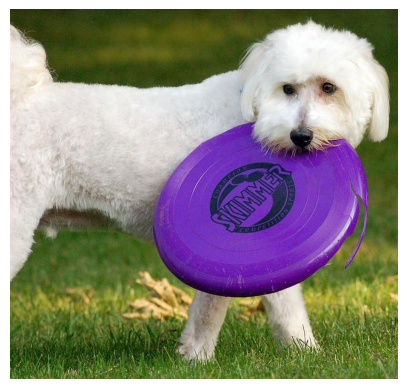

In [8]:
from PIL import Image
from transformers.image_utils import load_image

img_path = "imgs/frisbee.jpg"
image = load_image(img_path)
plt.axis("off")
_ = plt.imshow(image)

In [20]:
from getAttentionLib import get_response, get_attention, dump_attn, get_img_grid_sizes, plot_mult_attn_sums

text = "<image>What color is the frisbee?"

inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)
inputs.pixel_values = inputs.pixel_values[:, :1, :, :, :]
print(inputs.pixel_values.shape)
print(inputs.keys())
print(inputs.input_ids)
input_tokens = processor.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
outputs = model.generate(**inputs, max_new_tokens=100)
response: str = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)


print('inputs_tokens')
print(input_tokens)
print(outputs)

print('\nResponse:')
print(response)


# Prepare inputs
# inputs_tokens, response = get_response(model, processor, prompt, image)
# print(inputs_tokens)
# print(response)


torch.Size([1, 1, 3, 384, 384])
dict_keys(['pixel_values', 'pixel_attention_mask', 'input_ids', 'attention_mask'])
tensor([[49152,    44,   720,  ...,  4593, 20728,    47]], device='cuda:0')
pixel_values shape: torch.Size([17, 3, 384, 384])
patch_attention_mask shape: torch.Size([17, 27, 27])
image_hidden_states shape: torch.Size([17, 729, 1152])
image_hidden_states shape: torch.Size([17, 81, 2048])
num_images: 17, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1556])
input_ids: tensor([[49152,    44,   720,  ...,  4593, 20728,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1556])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1556, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1556, 2048])
reshaped_image_hidden_states shape: torch.Size([1377, 2048])
reshaped_image_hidd

In [24]:
# text = "<image>What color is the frisbee?"
# inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)

# # Check dimensions of inputs
# print("Input IDs shape:", inputs.input_ids.shape, inputs.input_ids[:13])
# print("Image embeddings shape:", inputs.image_embeds.shape if hasattr(inputs, 'image_embeds') else "No direct image embeddings")

# # Get attention from first layer to see actual dimensions
# outputs = model(input_ids=inputs.input_ids, image=image, output_attentions=True)
# first_layer_attention = outputs.attentions[0]
# print("\nAttention shape:", first_layer_attention.shape)

# Create Multimodal Attention Visualization

# Plot Region-wise Attention

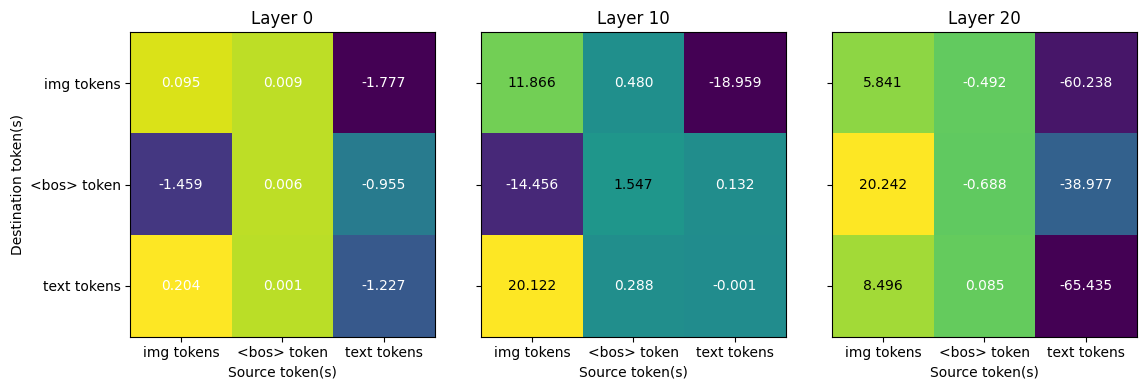

In [8]:
fig = plot_mult_attn_sums(model, inputs, layers=[0, 10, 20])
fig.savefig("imgs/blockwise-attn-sums-frisbee.png")
fig.show()

# Verify Numbers on VQA

In [28]:
import tqdm
from getAttentionLib import compute_mult_attn_sums, load_vqa_ds, plot_images_grid

n_vqa_samples = 15 # 1000
ds = load_vqa_ds(split="train")

layers = [0, 10, 20]
attens_tensor = []
responses = []
imgs = []
seen_imgs = set()
pbar = tqdm.tqdm(total=n_vqa_samples)
for row in ds:
    if len(imgs) >= n_vqa_samples:
        break

    if row["image_id"] in seen_imgs:
        continue
    seen_imgs.add(row["image_id"])
    print(row['question'])
    text = f"<image>{row['question']}"
    try:
        inputs = processor(text=text, images=row["image"], return_tensors="pt").to(model.device)
    except ValueError as e: # Unsupported number of image dimensions: 2
        if 'Unsupported number' in str(e):
            continue

    response = get_response(model, processor, text, row["image"])[1]
    #responses.append(response.replace("\n", " A: ").replace("Answer en", "Q:"))
    question = text.strip('<image>')
    responses.append(question + '|' + response.split(question)[1])
    
    imgs.append(row["image"])
    
    mult_attn_sums = compute_mult_attn_sums(model, inputs, layers=layers)
    attens_tensor.append(torch.stack(mult_attn_sums))
    
    pbar.update(1)
pbar.close()
    
stacked_attens = torch.stack(attens_tensor)
assert stacked_attens.shape == (n_vqa_samples, len(layers), 3, 3)

Repo card metadata block was not found. Setting CardData to empty.
  0%|          | 0/15 [00:00<?, ?it/s]

What is this photo taken looking through?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1191])
input_ids: tensor([[49152,    44,   720,  ...,  3012,   738,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1191])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1191, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1191, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size

  7%|▋         | 1/15 [00:04<01:01,  4.40s/it]

tensor([[49152,    44,   720,  ...,  3012,   738,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1191])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1191, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1191, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1191, 2048])
What color is the snow?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1190])
input_ids: 

 13%|█▎        | 2/15 [00:06<00:42,  3.27s/it]

tensor([[49152,    44,   720,  ...,   260,  5806,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1190])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1190, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1190, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1190, 2048])
What is in the person's hand?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1191])
input

 20%|██        | 3/15 [00:11<00:46,  3.86s/it]

tensor([[49152,    44,   720,  ...,   506,  1369,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1191])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1191, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1191, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1191, 2048])
Is the sky blue?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1189])
input_ids: tensor(

 27%|██▋       | 4/15 [00:15<00:45,  4.12s/it]

tensor([[49152,    44,   720,  ...,  6376,  4461,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1189])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1189, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1189, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1189, 2048])
Is the window open?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1188])
input_ids: tens

 33%|███▎      | 5/15 [00:20<00:42,  4.26s/it]

tensor([[49152,    44,   720,  ...,  5700,  1440,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1188])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1188, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1188, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1188, 2048])
Is the man smiling?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1189])
input_ids: tens

 40%|████      | 6/15 [00:22<00:32,  3.63s/it]

tensor([[49152,    44,   720,  ...,   555, 30291,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1189])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1189, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1189, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1189, 2048])
Judging from the dress, was this taken in a Latin American country?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_

 47%|████▋     | 7/15 [00:25<00:26,  3.27s/it]

tensor([[49152,    44,   720,  ...,  1547,  1798,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1198])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1198, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1198, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1198, 2048])
Does the guy have a tattoo?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1191])
input_i

 53%|█████▎    | 8/15 [00:27<00:20,  2.97s/it]

tensor([[49152,    44,   720,  ...,   253, 31376,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1191])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1191, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1191, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1191, 2048])
What color is the jacket?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1189])
input_ids

 60%|██████    | 9/15 [00:32<00:20,  3.42s/it]

tensor([[49152,    44,   720,  ...,   260, 29111,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1189])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1189, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1189, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1189, 2048])
What is on the pillow?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1189])
input_ids: t

 67%|██████▋   | 10/15 [00:36<00:18,  3.70s/it]

tensor([[49152,    44,   720,  ...,   260, 33833,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1189])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1189, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1189, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1189, 2048])
What is this person doing?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1189])
input_id

 73%|███████▎  | 11/15 [00:40<00:15,  3.94s/it]

tensor([[49152,    44,   720,  ...,  1055,  2567,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1189])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1189, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1189, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1189, 2048])
What is the dog riding on?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1190])
input_id

 80%|████████  | 12/15 [00:45<00:12,  4.12s/it]

tensor([[49152,    44,   720,  ..., 13948,   335,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1190])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1190, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1190, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1190, 2048])
What does the green light, on the TV, indicate?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Siz

 87%|████████▋ | 13/15 [00:49<00:08,  4.18s/it]

tensor([[49152,    44,   720,  ...,    28,  5521,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1196])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1196, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1196, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1196, 2048])
What color is the bear?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1189])
input_ids: 

 93%|█████████▎| 14/15 [00:54<00:04,  4.23s/it]

tensor([[49152,    44,   720,  ...,   260,  7012,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1189])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1189, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1189, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1189, 2048])
Are there rocks in the picture?
pixel_values shape: torch.Size([13, 3, 384, 384])
patch_attention_mask shape: torch.Size([13, 27, 27])
image_hidden_states shape: torch.Size([13, 729, 1152])
image_hidden_states shape: torch.Size([13, 81, 2048])
num_images: 13, vision_hidden_size: 2048
input_ids shape: torch.Size([1, 1190])
inp

100%|██████████| 15/15 [00:58<00:00,  3.90s/it]

tensor([[49152,    44,   720,  ...,   260,  4177,    47]], device='cuda:0')
self.image_token_id: 49153
special_image_token_mask shape: torch.Size([1, 1190])
special_image_token_mask: tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
inputs_embeds shape: torch.Size([1, 1190, 2048])
inputs_embeds dtype: torch.bfloat16
inputs_embeds device: cuda:0
new_inputs_embeds shape: torch.Size([1, 1190, 2048])
reshaped_image_hidden_states shape: torch.Size([1053, 2048])
reshaped_image_hidden_states after casting - dtype: torch.bfloat16
reshaped_image_hidden_states after casting - device: cuda:0
final new_inputs_embeds shape: torch.Size([1, 1190, 2048])


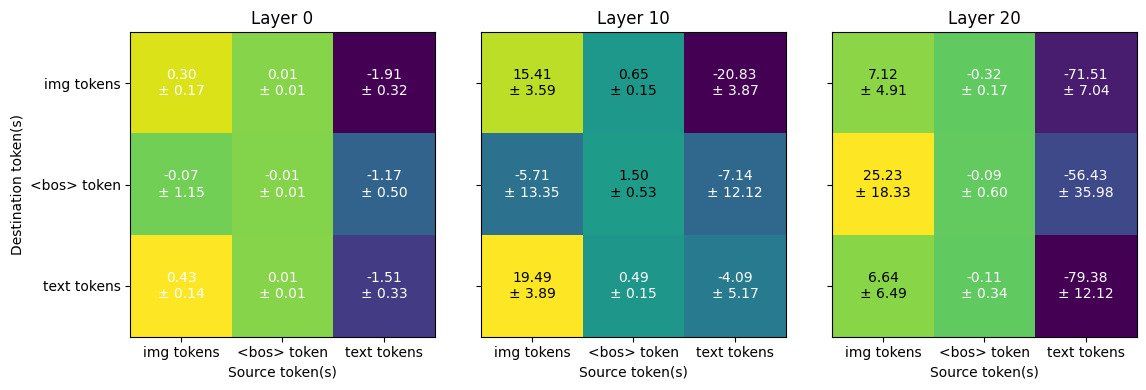

In [10]:
means = stacked_attens.mean(dim=0)
assert means.shape == (len(layers), 3, 3)
stds = stacked_attens.std(dim=0)
assert stds.shape == (len(layers), 3, 3)
fig = plot_mult_attn_sums(None, None,layers=layers, mult_attn_sums=means, stds=stds)
fig.savefig("imgs/blockwise-attn-sums-vqa1000.png")
fig.show()

# Show VQA Grid

In [19]:
import textwrap

def process_response(r: str) -> str:
    q, a = r.split('|')
    first_response = a.split('.')[0].split('?')[0]
    chars_per_line = 20
    
    # Wrap text to fit within subplot
    a = textwrap.fill(first_response, width=chars_per_line)
    return f"Q: {q}\nA: {a}"

process_response(responses[0])

What is this photo taken looking through?|  A net.  A fence.  A wall.  A window.  A door.  A tree.  A car.  A house.  A mountain.  A river.  A lake.  A forest.  A desert.  A city.  A town.  A village.  A farm.  A field.  A meadow.  A pasture.  A golf course.  A tennis court.  A basketball court.  A soccer field.
What is this photo taken looking through?   A net


'Q: What is this photo taken looking through?\nA:   A net'

What is this photo taken looking through?|  A net.  A fence.  A wall.  A window.  A door.  A tree.  A car.  A house.  A mountain.  A river.  A lake.  A forest.  A desert.  A city.  A town.  A village.  A farm.  A field.  A meadow.  A pasture.  A golf course.  A tennis court.  A basketball court.  A soccer field.
What is this photo taken looking through?   A net
What color is the snow?| White.
What color is the snow?  White
What is in the person's hand?| a frisbee? 2 frisbees? 3 frisbees? 4 frisbees? 5 frisbees? 6 frisbees? 7 frisbees? 8 frisbees? 9 frisbees? 10 frisbees? 11 frisbees? 12 frisbees? 13 frisbees? 14 frisbees? 15 frisbees? 16 fris
What is in the person's hand?  a frisbee
Is the sky blue?| Yes it is. 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 
Is the sky blue?  Yes it is
Is the window open?| Yes or no? 
Yes. 
No. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
No. 
Yes. 
N

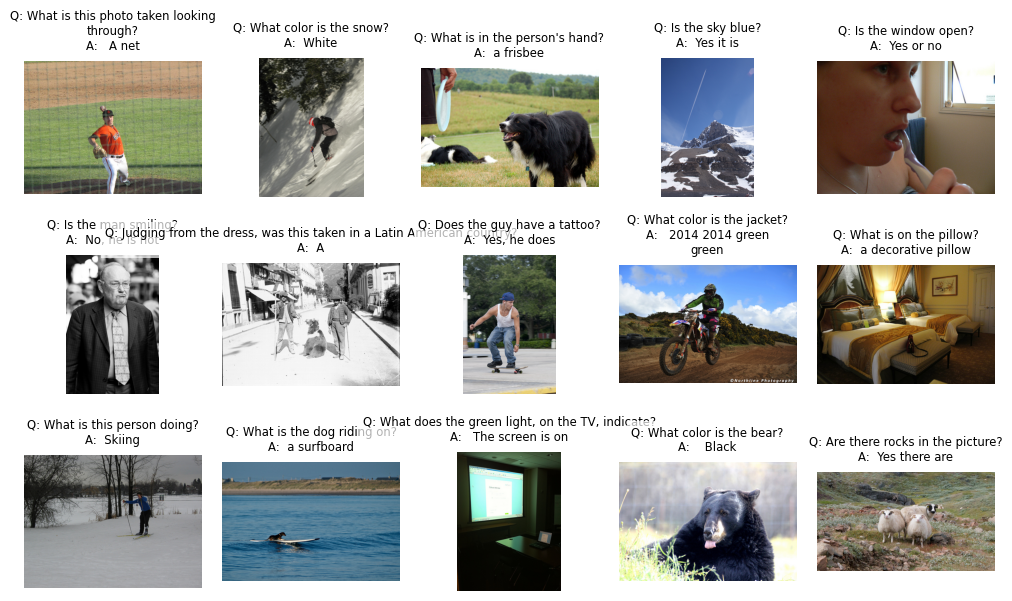

In [20]:
proc_responses = [process_response(r) for r in responses]
fig = plot_images_grid(imgs[:15], proc_responses[:15], nrows=3, ncols=5, figsize=(10, 6))
fig.savefig("imgs/vqa-grid-of-img-question-answer.png")
fig.show()